# Домашнее задание «Сегментация и детекция объектов»
Распознавание рукописного ввода на примере базы MNIST

Классификатор предлагается строить на признаках, полученных в результате предобработки изображений, например, гистограммы градиентов (HOG) или результат PCA преобразования.

**Кулешов Иван AML-14**

In [60]:
import cv2
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

Загружаем исходные данные

In [53]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Данные взяты непосредственно со страницы соревнования https://www.kaggle.com/c/digit-recognizer, тестовая выборка не содержит значений о классе изображения

In [61]:
train_data = np.loadtxt('/content/drive/MyDrive/Netology-homework/6 CVML Компьютерное зрение/train.csv', delimiter=',', skiprows=1)
test_data = np.loadtxt('/content/drive/MyDrive/Netology-homework/6 CVML Компьютерное зрение/test.csv', delimiter=',', skiprows=1)

In [62]:
X = train_data[:, 1:]
y = train_data[:, 0]

Разбиваем на обучающую и тестовую выборку

In [63]:
from sklearn.model_selection import train_test_split

train, test, train_label, test_label = train_test_split(X, y, test_size=0.2, random_state=66)


In [2]:
"""
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', cache=False)
X = mnist.data.astype('float32')
y = mnist.target.astype('int64')

train = X[:42000]
test = X[42000:]
train_label = y[:42000]
test_label = y[42000:]
"""

Визуализируем примеры

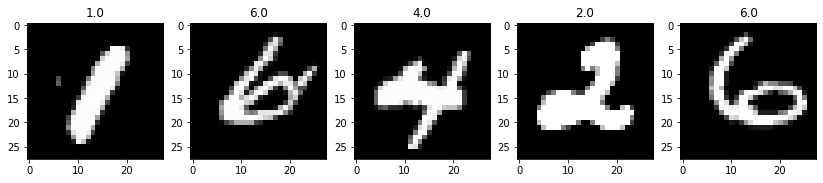

In [64]:
%matplotlib inline
from matplotlib import pyplot as plt
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(np.array(train[:5]).reshape(5,28,28),1):
    subplot = fig.add_subplot(1, 7, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % train_label[i - 1]);

# Классификатор на основе преобразования PCA

## Стандартизация данных

In [65]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

scaler.fit(train)

train_sc = scaler.transform(train)
test_sc = scaler.transform(test)

## Собственные числа

In [66]:
# матрица ковариации признаков
cov = np.dot(train_sc.T, train_sc) / train_sc.shape[0]

In [67]:
U, S, _ = np.linalg.svd(cov)
# U - собсвенные вектора матрицы ковариации
# S - собственные значения

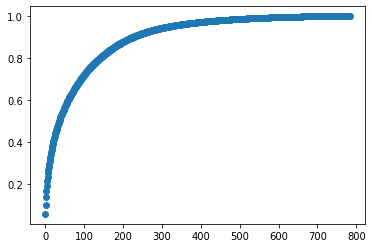

In [68]:
# накопленная сумма собственных значений
S_cumsum = np.cumsum(S) / np.sum(S)
plt.plot(S_cumsum, 'o')

In [69]:
for i in range(5):
    print('[%03d] %.3f' % (i, S_cumsum[i]))

[000] 0.058
[001] 0.099
[002] 0.138
[003] 0.167
[004] 0.193


## Понижаем размерность

In [70]:
S_thr = 0.8  # задаем порог для накопленной суммы собственных значений

# определяем необходимое число компонент для заданного порога
n_comp = np.argmax(np.where(S_cumsum >= S_thr, 1, 0))

print('n_comp=%d S=%.3f' % (n_comp, S_cumsum[n_comp]))

n_comp=141 S=0.802


In [71]:
# получаем сжатое представление объектов
train_img = np.dot(train_sc, U[:, :n_comp])
test_img = np.dot(test_sc, U[:, :n_comp])

## PCA из scikit-learn

Того же можно добиться, используя преобразование PCA из библиотеки scikit-learn, количество компонент определим таким образом, чтобы 80% дисперсии было ими обеспечено

In [72]:
from sklearn.decomposition import PCA

pca = PCA(0.8)

Обучим PCA на обучающей выборке и затем произведем для выборки понижение размерности:

In [73]:
pca.fit(train_sc)
train_pca = pca.transform(train_sc)
test_pca = pca.transform(test_sc)

Количество компонент для 80% дисперсии

In [74]:
pca.n_components_

142

## Модель классификации изображений

In [77]:
import warnings
warnings.filterwarnings('ignore')

In [75]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [76]:
# Словарь с моделями
models = {
    '1. LogisticRegression': LogisticRegression(multi_class='multinomial', solver='newton-cg'),
    '2. KNeighborsClassifier': KNeighborsClassifier(),
    '3. SVC': SVC(),
    '4. DecisionTreeClassifier': DecisionTreeClassifier(),
    '5. RandomForestClassifier': RandomForestClassifier(random_state=42),
    '6. LinearDiscriminantAnalysis': LinearDiscriminantAnalysis(),
}

In [78]:
# чтобы не городить много однотипных вызовов функций, сделаем в генераторе 
gen_models = {name_model:
            models[name_model].fit(train_img, train_label) for name_model in models}


In [79]:
for model_name,model in gen_models.items():
  print(f'модель: {model_name}\n \
  train_score = {model.score(train_img, train_label):.4f}, \
  test_score = {model.score(test_img, test_label):.4f}')

модель: 1. LogisticRegression
   train_score = 0.9304,   test_score = 0.9235
модель: 2. KNeighborsClassifier
   train_score = 0.9666,   test_score = 0.9502
модель: 3. SVC
   train_score = 0.9829,   test_score = 0.9660
модель: 4. DecisionTreeClassifier
   train_score = 1.0000,   test_score = 0.8135
модель: 5. RandomForestClassifier
   train_score = 1.0000,   test_score = 0.9406
модель: 6. LinearDiscriminantAnalysis
   train_score = 0.8682,   test_score = 0.8655


По итогам выбираем модель опорных векторов SVC, показавшую лучший результат.

In [18]:
from sklearn.model_selection import KFold, cross_val_score

model_pca = SVC(random_state=42)
folds = KFold(n_splits=5, shuffle=True, random_state=42)
score = cross_val_score(estimator=model_pca, X=train_img, y=train_label, scoring='accuracy', cv=folds, n_jobs=-1)
print(f'Процент точности на k-разбиениях: {score}')
print(f'Среднее точности: {score.mean()}')

Процент точности на k-разбиениях: [0.96357143 0.96607143 0.96380952 0.9675     0.96369048]
Среднее точности: 0.9649285714285714


Можно увидеть, как модель SVC показывает стабильную предсказательную силу на 5 разбиениях

In [80]:
from sklearn.metrics import accuracy_score

model_pca = SVC(random_state=42).fit(train_img, train_label)
y_train_pred = model_pca.predict(train_img)
y_test_pred = model_pca.predict(test_img)

print(f'accuracy train: {accuracy_score(y_true=train_label, y_pred=y_train_pred)}')
print(f'accuracy test: {accuracy_score(y_true=test_label, y_pred=y_test_pred)}')

accuracy train: 0.9829464285714286
accuracy test: 0.965952380952381


# Классификатор на основе гистограммы градиентов (HOG)

In [81]:
# приводим размерность к удобному для обработки виду
train_img = np.resize(train, (train.shape[0], 28, 28))
test_img = np.resize(test, (test.shape[0], 28, 28))

## Вычисляем X и Y составляющие градиента с помощью оператора Собеля

In [82]:
train_sobel_x = np.zeros_like(train_img)
train_sobel_y = np.zeros_like(train_img)
for i in range(len(train_img)):
    train_sobel_x[i] = cv2.Sobel(train_img[i], cv2.CV_64F, dx=1, dy=0, ksize=1)
    train_sobel_y[i] = cv2.Sobel(train_img[i], cv2.CV_64F, dx=0, dy=1, ksize=1)

In [83]:
test_sobel_x = np.zeros_like(test_img)
test_sobel_y = np.zeros_like(test_img)
for i in range(len(test_img)):
    test_sobel_x[i] = cv2.Sobel(test_img[i], cv2.CV_64F, dx=1, dy=0, ksize=1)
    test_sobel_y[i] = cv2.Sobel(test_img[i], cv2.CV_64F, dx=0, dy=1, ksize=1)

## Вычисляем угол и длину вектора градиента

In [84]:
# насколько понимаю train_g - магнитуда градиента (длина), а train_theta - направление градиента (угол)
train_g, train_theta = cv2.cartToPolar(train_sobel_x, train_sobel_y)
train_sobel_x=None
train_sobel_y=None

In [85]:
test_g, test_theta = cv2.cartToPolar(test_sobel_x, test_sobel_y)
test_sobel_x=None
test_sobel_y=None

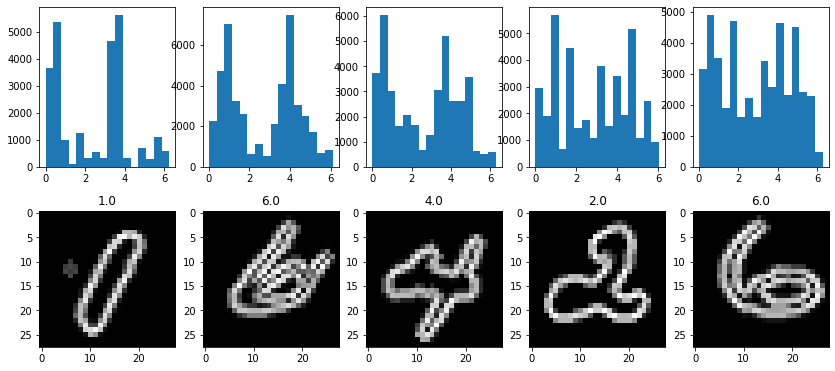

In [86]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(train_g[:5], 1):
    subplot = fig.add_subplot(1, 7, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % train_label[i - 1]);
    subplot = fig.add_subplot(3, 7, i)
    plt.hist(train_theta[i - 1].flatten(),
             bins=16, weights=train_g[i - 1].flatten())

In [87]:
train_theta.shape

(33600, 28, 28)

## Вычисляем гистограммы градиентов

In [88]:
np.histogram(train_theta[1],bins=16,range=(0., 2. * np.pi),weights=train_g[1])

(array([2274.94357195, 6057.15118538, 6334.66995167, 3281.40981027,
        2104.15768304,  460.4905452 , 1134.4325161 ,  591.09764314,
        2522.2918386 , 5791.33978123, 6435.74572777, 2417.81667485,
        2527.6157314 , 1268.68146939,  839.03671786,  537.83394325]),
 array([0.        , 0.39269908, 0.78539816, 1.17809725, 1.57079633,
        1.96349541, 2.35619449, 2.74889357, 3.14159265, 3.53429174,
        3.92699082, 4.3196899 , 4.71238898, 5.10508806, 5.49778714,
        5.89048623, 6.28318531]))

In [89]:
# Гистограммы вычисляются с учетом длины вектора градиента
train_hist = np.zeros((len(train_img), 64))
for i in range(len(train_img)):
    hist, borders = np.histogram(train_theta[i],
                                 bins=64,
                                 range=(0., 2. * np.pi),
                                 weights=train_g[i])
    train_hist[i] = hist
    borders=None

In [90]:
test_hist = np.zeros((len(test_img), 64))
for i in range(len(test_img)):
    hist, borders = np.histogram(test_theta[i],
                                 bins=64,
                                 range=(0., 2. * np.pi),
                                 weights=test_g[i])
    test_hist[i] = hist
    borders=None

## Нормируем вектор гистограммы

In [91]:
#  объединим гистограммы, нормируем и затем разделим обратно
total_hist=np.concatenate([train_hist,test_hist])

In [92]:
total_hist = total_hist / np.linalg.norm(total_hist, axis=1)[:, None]
train_hist=total_hist[:train_hist.shape[0]]
test_hist=total_hist[train_hist.shape[0]:]
total_hist=None

## Обучим классификатор

In [93]:
# чтобы не городить много однотипных вызовов функций, сделаем в генераторе 
gen_models = {name_model:
            models[name_model].fit(train_hist, train_label) for name_model in models}


In [94]:
for model_name,model in gen_models.items():
  print(f'модель: {model_name}\n \
  train_score = {model.score(train_hist,train_label):.4f}, \
  test_score = {model.score(test_hist,test_label):.4f}')

модель: 1. LogisticRegression
   train_score = 0.5987,   test_score = 0.5890
модель: 2. KNeighborsClassifier
   train_score = 0.6387,   test_score = 0.5014
модель: 3. SVC
   train_score = 0.6976,   test_score = 0.6582
модель: 4. DecisionTreeClassifier
   train_score = 1.0000,   test_score = 0.3918
модель: 5. RandomForestClassifier
   train_score = 1.0000,   test_score = 0.5846
модель: 6. LinearDiscriminantAnalysis
   train_score = 0.5686,   test_score = 0.5611


Можно заметить, что качество предсказания для признаков построенных на основе гистограммы градиентов сильно уступает моделям, построенных на признаках после преобразования PCA. Модели на деревьях при этом переучились.

Лучший результат снова показала модель SVC.

# Оценка качества решения

Лучше всего себя показала модель SVC с итоговой метрикой accuracy на тестовой выборке:

In [95]:
accuracy_score(y_true=test_label, y_pred=y_test_pred)

0.965952380952381

Посмотрим на матрицы предсказания классов

In [96]:
from sklearn.metrics import classification_report

print(classification_report(test_label, y_test_pred))

              precision    recall  f1-score   support

         0.0       0.98      0.98      0.98       780
         1.0       0.98      0.99      0.98       900
         2.0       0.96      0.97      0.96       833
         3.0       0.96      0.95      0.96       876
         4.0       0.97      0.96      0.96       866
         5.0       0.96      0.96      0.96       735
         6.0       0.99      0.98      0.98       856
         7.0       0.94      0.96      0.95       869
         8.0       0.97      0.95      0.96       842
         9.0       0.96      0.95      0.95       843

    accuracy                           0.97      8400
   macro avg       0.97      0.97      0.97      8400
weighted avg       0.97      0.97      0.97      8400



In [97]:
from sklearn.metrics import confusion_matrix

print(confusion_matrix(test_label, y_test_pred))

[[765   0   7   0   0   1   3   2   2   0]
 [  0 890   3   3   2   0   1   1   0   0]
 [  3   4 809   4   1   0   2   7   1   2]
 [  0   0   7 836   0  10   1   7  10   5]
 [  1   1   9   0 832   1   1   6   0  15]
 [  1   1   1  14   2 704   2   4   5   1]
 [  3   1   0   0   1   5 840   5   1   0]
 [  2   7   5   2   6   0   0 837   1   9]
 [  1   6   4   8   3   8   1   4 802   5]
 [  1   1   1   6  15   2   0  14   4 799]]


## Визуализируем предсказания

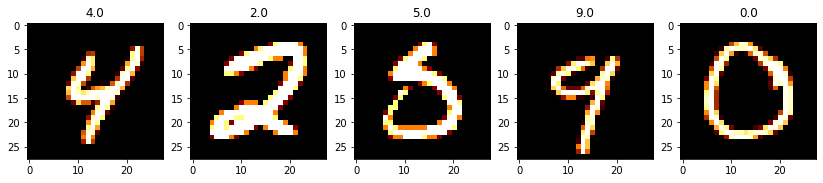

In [98]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(test_img[:5], 1):
    subplot = fig.add_subplot(1, 7, i)
    plt.imshow(img, cmap='afmhot');
    subplot.set_title('%s' % y_test_pred[i-1]);

## Готовим файл для отправки

Во-первых, нужно применить стандартизацию, выученную на train:

In [100]:
test_sc = scaler.transform(test_data)

Во-вторых, применим понижение размерности для тестовых данных:

In [102]:
test_img = np.dot(test_sc, U[:, :n_comp])

В-третих, получить предсказания для тестовой выборке от лучшей модели - SVC, построенной на преобразованных PCA данных:

In [103]:
y_test_pred = model_pca.predict(test_img)

Сформируем файл с предсказанными значениями для отправки на страницу с соревнованием

In [111]:
with open('submit.csv', 'w') as dst:
    dst.write('ImageId,Label\n')
    for i, p in enumerate(y_test_pred, 1):
        dst.write('%s,%s\n' % (i, int(p)))

Скрин с загруженным на kaggle результатом:

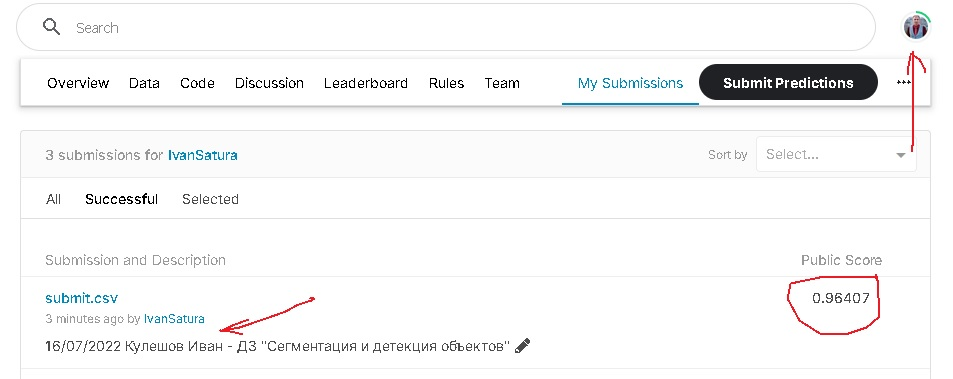